In [38]:
import numpy as np
import xarray as xr
import pandas as pd

# Load SST and grid data (assume same for both JRA and CORE2)
npz = np.load('sstu_1993_2022.npz', allow_pickle=True)
print("Keys in the npz file:", npz.keys())
sst = npz["sstc"]
coast = npz["coast"]
lono = npz["lonc"]
lato = npz["latc"]
time = npz["time"]
lat = np.mean(lato, axis=1)  

# Prepare heat budget list: [JRA, CORE2]
fname = 'heat_budget_mld1_fjra_1993_2022.npz'
npz = np.load(fname, allow_pickle=True)
budget = {
    'tdc': npz['tdc_c'],
    'advx': npz['advx_c'],
    'advy': npz['advy_c'],
    'advz': npz['advz_c'],
    'sbc': npz['sbc_c'],
    'diffv': npz['diffv_c'],
}
budget_errors = {
    'tdc': npz['tdc_c_std'],
    'advx': npz['advx_c_std'],
    'advy': npz['advy_c_std'],
    'advz': npz['advz_c_std'],
    'sbc': npz['sbc_c_std'],
    'diffv': npz['diffv_c_std'],
}

# Now heat_budgets[0] is JRA, heat_budgets[1] is CORE2, each a dict with all terms and a label


Keys in the npz file: KeysView(NpzFile 'sstu_1993_2022.npz' with keys: lon, lat, sstu, sstc, coast...)


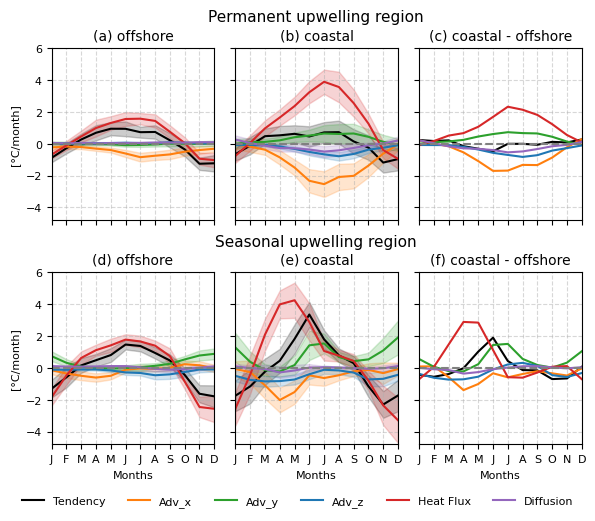

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
panel_labels = list("abcdefghijklmnopqrstuvwxyz")

def plot_budget_results(lat, budget_terms, budget_errors, latitude_bands):
    """Plot the mean evolution of budget terms for specified latitude bands with shaded error regions."""
    
    labels = ["Tendency", "Adv_x", "Adv_y", "Adv_z", "Heat Flux", "Diffusion"]
    colors = {
        "Tendency": "k", 
        "Adv_x": "tab:orange",
        "Adv_y": "tab:green", 
        "Adv_z": "tab:blue",
        "Heat Flux": "tab:red", 
        "Diffusion": "tab:purple",
    }
    row_titles = ["Permanent upwelling region", "Seasonal upwelling region"]

    dt = 86400 * 30  # seconds in 1 month
    fig, axes = plt.subplots(len(latitude_bands), 3, figsize=(6, 5), sharex=True, sharey=True)

    for row, (lat_min, lat_max) in enumerate(latitude_bands):
        mask = (lat >= lat_min) & (lat <= lat_max)
        for col in range(3):  # 0: offshore, 1: coastal, 2: diff
            ax = axes[row, col]

            terms = [budget['tdc'], budget['advx'], budget['advy'], budget['advz'], budget['sbc'], budget['diffv']]
            errors = [budget_errors['tdc'], budget_errors['advx'], budget_errors['advy'], budget_errors['advz'], budget_errors['sbc'], budget_errors['diffv']]
            for term, error, label in zip(terms, errors, labels):

                color = colors.get(label, None)
                linestyle = "--" if label == "Sum" else "-"  

                if col == 0:  # offshore
                    mean_evolution = np.nanmean(term[:, mask, :8], axis=(1, 2)) * dt
                    std_error = np.nanmean(error[:, mask, :8], axis=(1, 2)) * dt if error is not None else None
                elif col == 1:  # coastal
                    mean_evolution = np.nanmean(term[:, mask, 8:], axis=(1, 2)) * dt
                    std_error = np.nanmean(error[:, mask, 8:], axis=(1, 2)) * dt if error is not None else None
                else:  # diff (coastal - offshore)
                    mean_coastal = np.nanmean(term[:, mask, 8:], axis=(1, 2))
                    mean_offshore = np.nanmean(term[:, mask, :8], axis=(1, 2))
                    mean_evolution = (mean_coastal - mean_offshore) * dt
                    std_error = None  

                ax.plot(range(term.shape[0]), mean_evolution, 
                        label=label if row == 0 and col == 0 else "_nolegend_", 
                        color=color, linestyle=linestyle)
                
                if std_error is not None and col < 2:
                    ax.fill_between(range(term.shape[0]), mean_evolution - std_error, mean_evolution + std_error, color=color, alpha=0.2, label="_nolegend_")


            ax.axhline(0, linestyle='dashed', color='gray')
            ax.grid(True, linestyle='--', alpha=0.5)

            ax.set_ylim(-4.8, 6)
            ax.set_xlim(0, term.shape[0] - 1)
            panel_idx = row * 3 + col
            prefix = f"({panel_labels[panel_idx]}) "
            title = ["offshore", "coastal", "coastal - offshore"][col]
            ax.set_title(f"{prefix}{title}", fontsize=10)
            if col == 0:
                ax.set_ylabel("[°C/month]")

    for ax in axes[-1, :]:  
        ax.set_xticks(range(12))
        ax.set_xticklabels(month_labels)
        ax.set_xlabel("Months")

    fig.legend(labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(labels), frameon=False)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    fig.subplots_adjust(hspace=0.3)  


    row_titles = [
        "Permanent upwelling region",
        "Seasonal upwelling region"
    ]

    for i, title in enumerate(row_titles):
        y = 1.0 - (i + 0.5) * .45 + 0.16

        fig.text(
            0.53, y, title,
            ha='center', va='bottom',
            fontsize=11
        )

    

# Latitude bands
latitude_bands = [(21, 30), (12, 19)]
month_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plot_budget_results(lat, 
                    budget,  
                    budget_errors,  
                    latitude_bands)
plt.savefig("fig8.png", dpi=300, bbox_inches='tight')                    
plt.show()